c:\users\sedra\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sedra\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sedra\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\sedra\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

../Data/Images/H6/A1H6COL_15.tif ../Data/Labels/Labeled H6/A1H6COL_15.json
../Data/Images/H6/A1H6COL_16.tif ../Data/Labels/Labeled H6/A1H6COL_16.json
../Data/Images/H6/A1H6COL_17.tif ../Data/Labels/Labeled H6/A1H6COL_17.json
../Data/Images/H6/A1H6COL_18.tif ../Data/Labels/Labeled H6/A1H6COL_18.json
../Data/Images/H6/A1H6COL_19.tif ../Data/Labels/Labeled H6/A1H6COL_19.json
../Data/Images/H6/A1H6COL_21.tif ../Data/Labels/Labeled H6/A1H6COL_21.json
../Data/Images/H6/A1H6COL_210.tif ../Data/Labels/Labeled H6/A1H6COL_210.json
../Data/Images/H6/A1H6COL_211.tif ../Data/Labels/Labeled H6/A1H6COL_211.json
../Data/Images/H6/A1H6COL_212.tif ../Data/Labels/Labeled H6/A1H6COL_212.json
../Data/Images/H6/A1H6COL_213.tif ../Data/Labels/Labeled H6/A1H6COL_213.json
../Data/Images/H6/A1H6COL_214.tif ../Data/Labels/Labeled H6/A1H6COL_214.json
../Data/Images/H6/A1H6COL_215.tif ../Data/Labels/Labeled H6/A1H6COL_215.json
../Data/Images/H6/A1H6COL_216.tif ../Data/Labels/Labeled H6/A1H6COL_216.json
../Data/Ima

../Data/Images/J4R/A1J4COR_22.tif ../Data/Labels/Labeled J4R/A1J4COR_22.json
../Data/Images/J4R/A1J4COR_23.tif ../Data/Labels/Labeled J4R/A1J4COR_23.json
../Data/Images/J4R/A1J4COR_24.tif ../Data/Labels/Labeled J4R/A1J4COR_24.json
../Data/Images/J4R/A1J4COR_25.tif ../Data/Labels/Labeled J4R/A1J4COR_25.json
../Data/Images/J4R/A1J4COR_26.tif ../Data/Labels/Labeled J4R/A1J4COR_26.json
../Data/Images/J4R/A1J4COR_27.tif ../Data/Labels/Labeled J4R/A1J4COR_27.json
../Data/Images/J4R/A1J4COR_28.tif ../Data/Labels/Labeled J4R/A1J4COR_28.json
../Data/Images/K0R/A1K0COR_19.tif ../Data/Labels/Labeled K0R/A1K0COR_19.json
../Data/Images/K0R/A1K0COR_21.tif ../Data/Labels/Labeled K0R/A1K0COR_21.json
../Data/Images/K0R/A1K0COR_210.tif ../Data/Labels/Labeled K0R/A1K0COR_210.json
../Data/Images/K0R/A1K0COR_211.tif ../Data/Labels/Labeled K0R/A1K0COR_211.json
../Data/Images/K0R/A1K0COR_212.tif ../Data/Labels/Labeled K0R/A1K0COR_212.json
../Data/Images/K0R/A1K0COR_213.tif ../Data/Labels/Labeled K0R/A1K0COR_

the actual len of the gt vect is :  87
the actual len of the pred vect is :  87
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.05694444524124265
[0, 0, 0]
[0, 0, 0]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  94
the actual len of the pred vect is :  94
Average precision of this image :  0.1428571492433548
The actual mean average precision for the whole images (matterport methode)  0.06649030124147733
[1, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  166
the actual len of the pred vect is :  166
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.15409108235959024
[0, 0, 0]
[2, 2, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  210
the actual len of the pred vect is :  210
Average precision of this image :  0.1666666691501935
The actual mean average precision for the whole images (matterport methode)  0.15399743344123457
[1, 1, 1, 2, 2, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 2, 2, 2, 2]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  249
the actual len of the pred vect is :  249
Average precision of this image :  0.3333333432674408
The actual mean average precision for the whole images (matterport methode)  0.28764353368616274
[1, 0, 0, 0]
[1, 1, 0, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 2

the actual len of the gt vect is :  301
the actual len of the pred vect is :  301
Average precision of this image :  0.6000000238418579
The actual mean average precision for the whole images (matterport methode)  0.33628665710152206
[0, 0, 1, 1, 1]
[1, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  302
the actual len of the pred vect is :  302
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.33068187948316335
[0]
[1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  u

the actual len of the gt vect is :  348
the actual len of the pred vect is :  348
Average precision of this image :  0.6666666865348816
The actual mean average precision for the whole images (matterport methode)  0.3625281106301204
[1, 2, 1]
[1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  353
the actual len of the pred vect is :  353
Average precision of this image :  0.10000000149011612
The actual mean average precision for the whole images (matterport methode)  0.35893183516244914
[2, 1, 1, 1, 2]
[2, 1, 1, 1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    

the actual len of the gt vect is :  392
the actual len of the pred vect is :  392
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.4002852496300258
[1, 1, 0]
[1, 1, 2]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  394
the actual len of the pred vect is :  394
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.4072586769599092
[1, 0]
[1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images     

the actual len of the gt vect is :  434
the actual len of the pred vect is :  434
Average precision of this image :  1.0
The actual mean average precision for the whole images (matterport methode)  0.46517087998388174
[1, 0]
[1, 1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  436
the actual len of the pred vect is :  436
Average precision of this image :  0.0
The actual mean average precision for the whole images (matterport methode)  0.4604721842264688
[2, 2]
[1, 2]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images          

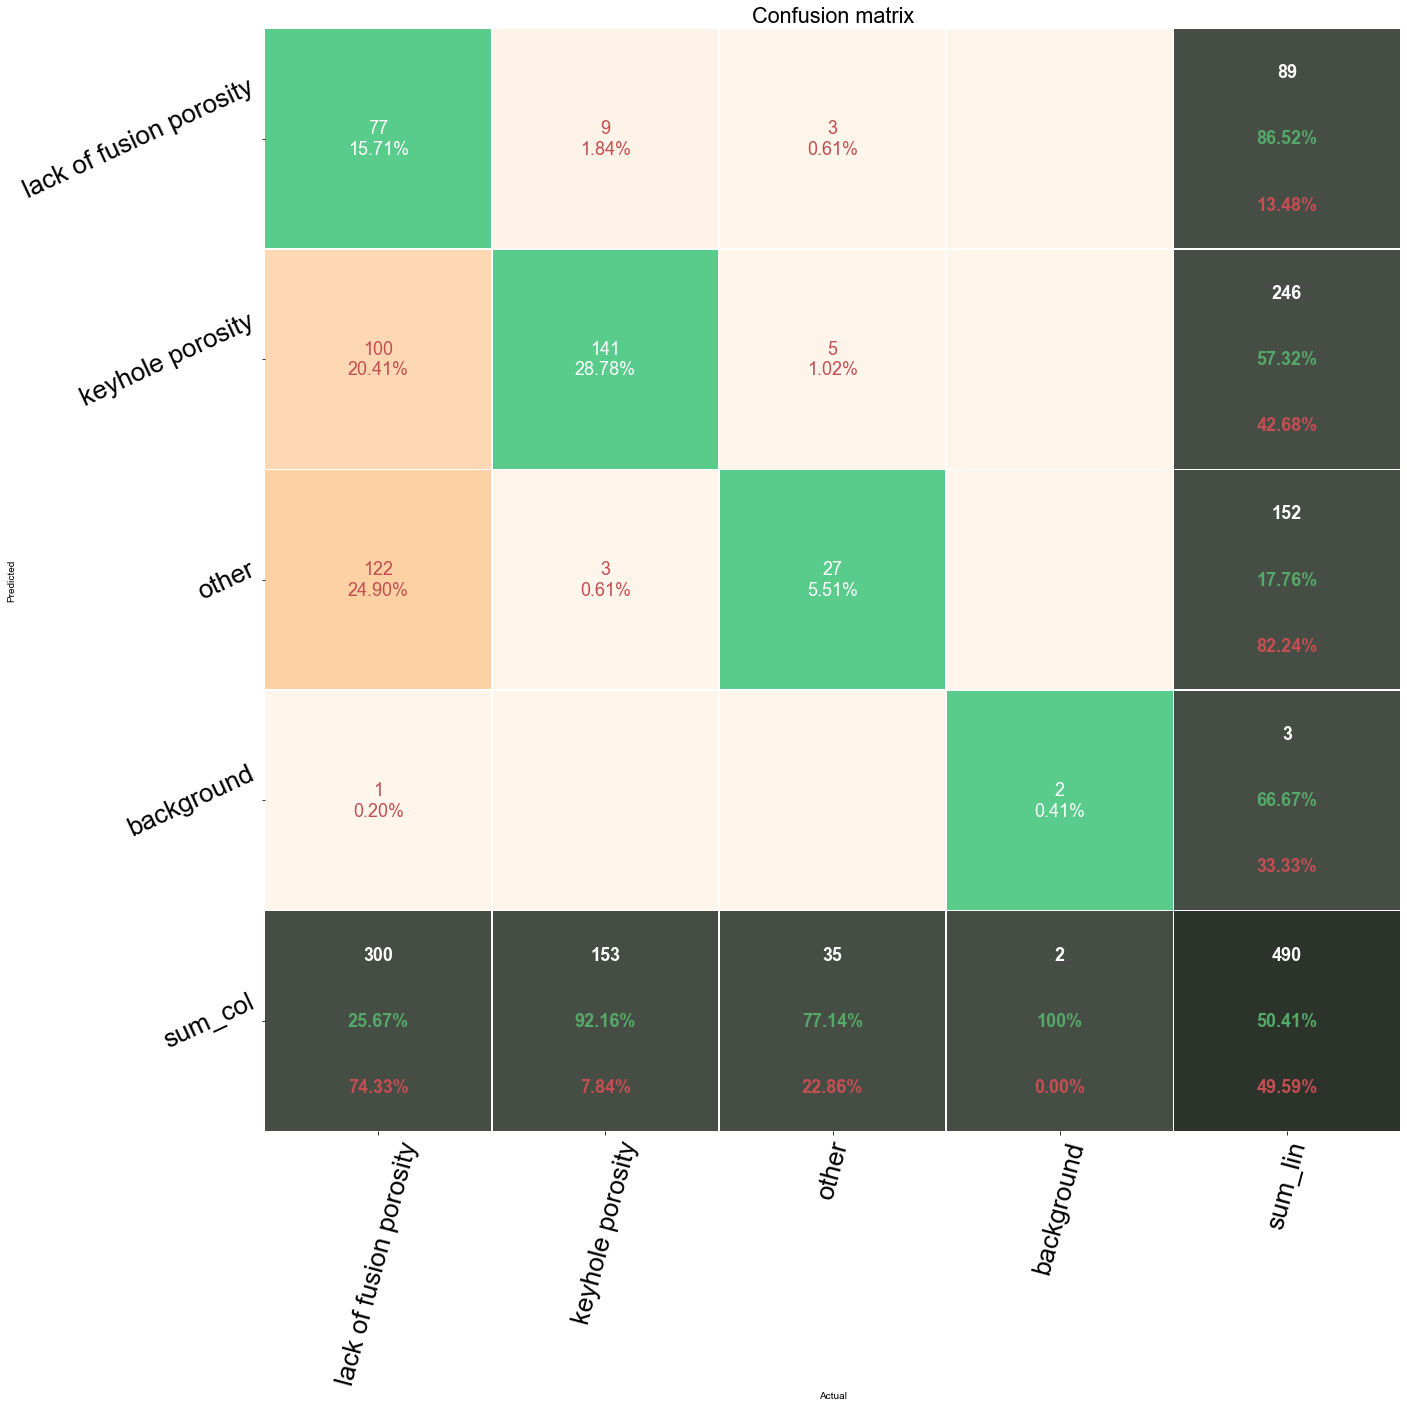

In [1]:
'''
Creates a confusion matrix from a set of images and a pre-loaded weight
Modified from: https://github.com/Altimis/Confusion-matrix-for-Mask-R-CNN
'''

# an example of plotting confusion matrix.
# the first step consists of computing ground-truth and prediction vectors for all images.
# using these vectors, the plot_confusion_matrix_from_data function plots the CM and computes tps fps and fns
from mrcnn import utils
import mrcnn.model
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
from mrcnn import utils
import pandas as pd
import numpy as np
import os 
import cv2
from dataset import Model_Dataset

#############################
# Configure inference model
#############################

class InferenceConfig(Config):
    NAME = 'inference'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3 + 1
       
config = InferenceConfig()
dataset = Model_Dataset()
dataset.ROOT_IMG_DIR = '../Data/Images/'
dataset.ROOT_ANNOTATION_DIR = '../Data/Labels/'
dataset.IMG_DIRS = ['H6', 'J8', 'J0', 'J4', 'R0', 'R6', 'J4R', 'K0R']
dataset.load_dataset(validation=True)
dataset.prepare()

model = MaskRCNN(mode='inference',
                 config=InferenceConfig(), model_dir='./')
model.load_weights(filepath='../weights/mrcnn-2-7.h5', by_name=True)

#############################
# Generate confusion matrix
#############################

#ground-truth and predictions lists
gt_tot = np.array([])
pred_tot = np.array([])
#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        mrcnn.model.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    #precision_, recall_, AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images (matterport methode) ", sum(mAP_)/len(mAP_))
    print(gt)
    print(pred)
#     print("Ground truth object : "+dataset.class_names[gt])
#     print("Predicted object : "+dataset.class_names[pred])
 

gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
    
#print the confusion matrix and compute true postives, false positives and false negative for each class: 
#ps : you can controle the figure size and text format by choosing the right values
#tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)

###########################################################################################################################

#since in this notebook i didnt run the loop above, here is an example of plotting using manual generated vectors :
#let 0 be the background class
#gt_tot=[1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,0,1,2,3,0,1,2,3,0,1,2,0]
#pred_tot=[1,2,3,3,2,1,1,2,3,1,2,3,1,2,0,2,2,2,3,1,0,0,3,2,1,2,0]

#supose we have 1 image containing the gt classes bellow :
gt_class_id = np.array([1,2,3,1,2,3])
#with the bbox :
gt_bbox = np.array([np.array([10,100,20,200]),np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([20,200,20,200]),
                    np.array([90,15,220,20]),np.array([100,10,150,20])])
#and the model detected the classes : 
pred_class_id = np.array([2,3,2,3,2,3])
#with the bbox : 
pred_bbox = np.array([np.array([100,10,200,20]),np.array([110,15,220,25]),np.array([90,15,220,20]),np.array([101,20,100,21]),
                    np.array([500,20,1,20]),np.array([100,10,150,20])])

#for this image, the gt and pred lists are :    
gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, pred_class_id, pred_bbox)
gt_tot = np.append(gt_tot, gt)
pred_tot = np.append(pred_tot, pred)

print("ground truth list : ",gt_tot)
print("predicted list : ",pred_tot)

#here i didnt set the columns list, since in the code if columns is note specified 
#it generates automatically a list from "class A" to "class ..". in this example, class A should be the background
#Note : class A is the backround in this example
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot, 
                                               columns=['lack of fusion porosity', 'keyhole porosity', 
                                                        'other', 'background'], 
                                               fz=18, figsize=(20,20), lw=0.5)